<center>

*******************************************************************************************
<font size="4">
Wavelet Coherence Transform &nbsp; &nbsp; <br>
</font>

##### 8 September 2025

##### Juan Ignacio Mendoza Garay

*******************************************************************************************

</center>

##### INFORMATION:

* The Wavelet Coherence Transform (WCT) measures the time-frequency relationship between two periodic signals at different time-scales.
>
* Dependency:
    * [PyCWT](https://github.com/regeirk/pycwt)
>
* Tested with:
    * Python 3.11
    * Matlab 2024b
    * Windows 11
>
* References:
    * Torrence, C., & Compo, G. P. (1998). A practical guide to wavelet analysis. *Bulletin of the American Meteorological society, 79*(1), 61-78.
    * Krieger, S., & Freij, N. (2024). *PyCWT: Wavelet spectral analysis in Python*. https://github.com/regeirk/pycwt
    * https://pycwt.readthedocs.io

>
* Instructions:
    * Ensure that the dependecies are installed.
    * Edit the values indicated with an arrow like this: <---

*******************************************************************************************

In [1]:
import sys

import numpy as np

sys.path.append(r"..\src")
import syncoord as sc

***
### Generate synthetic data

index; key; Name; duration (s):
  0; 0; Test Data; 0:16.0


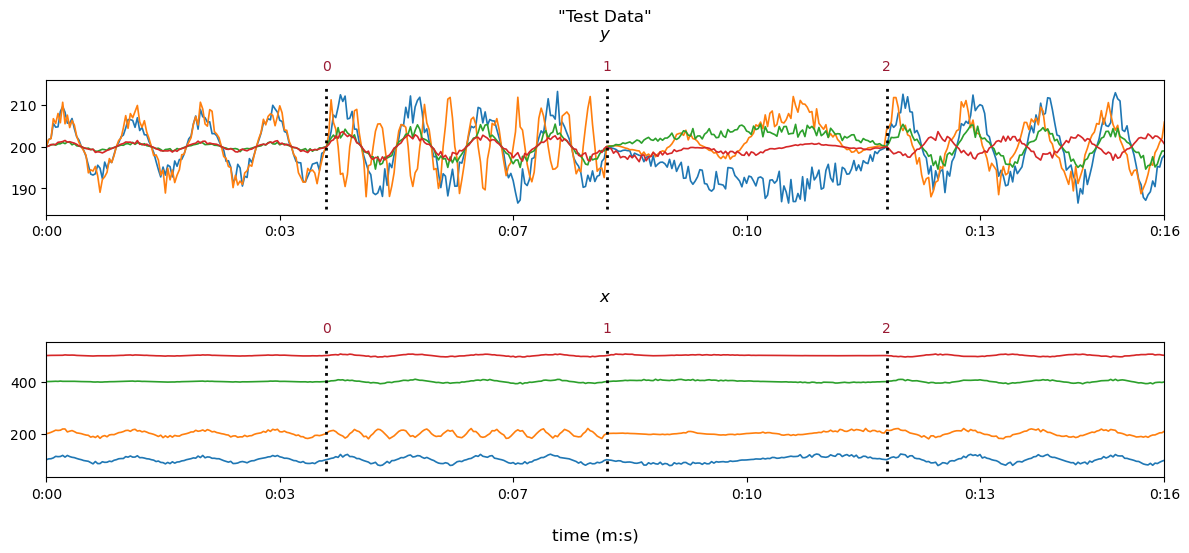

In [2]:
test_data_1= sc.ptdata.load( 'make', seed=1, print_info=True )
test_data_1.visualise( vscale=1.2, dlattr='1.2' )

***
### Reduce to 1 Dimension per point

Methods:
* Norms: the sum of the L1 and L2 norms preserve the shape of the oscillation and is not affected by noise.
* Speed: rectifies the oscillation and is affected by noise, leading to artifacts when applying the Fourier Transform.

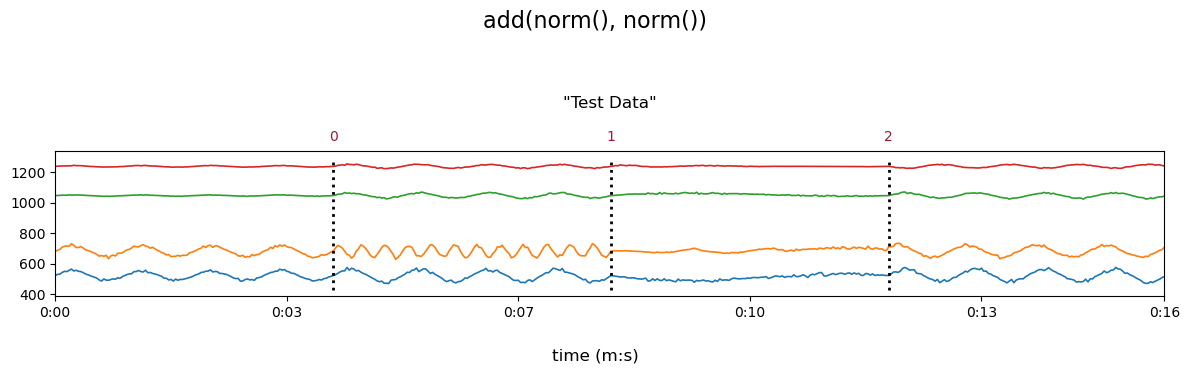

In [3]:
red1D_method = 'norms' # <--- 'norms' or 'speed'

if red1D_method == 'speed':
    test_data_2 = sc.ptdata.speed( test_data_1)
elif red1D_method == 'norms':
    n1 = sc.ptdata.norm( test_data_1, order=1, axis=-2 )
    n2 = sc.ptdata.norm( test_data_1, order=2, axis=-2 )
    test_data_2 = sc.ptdata.apply2( n1, n2, np.add )
else: raise Exception('invalid value for red1D_method')
test_data_2.visualise( vscale=1.4, dlattr='1.2' )

***
### Pairwise Wavelet Coherence Transform

In [4]:
test_data_1.names.dim

['point', 'axis', 'frame']

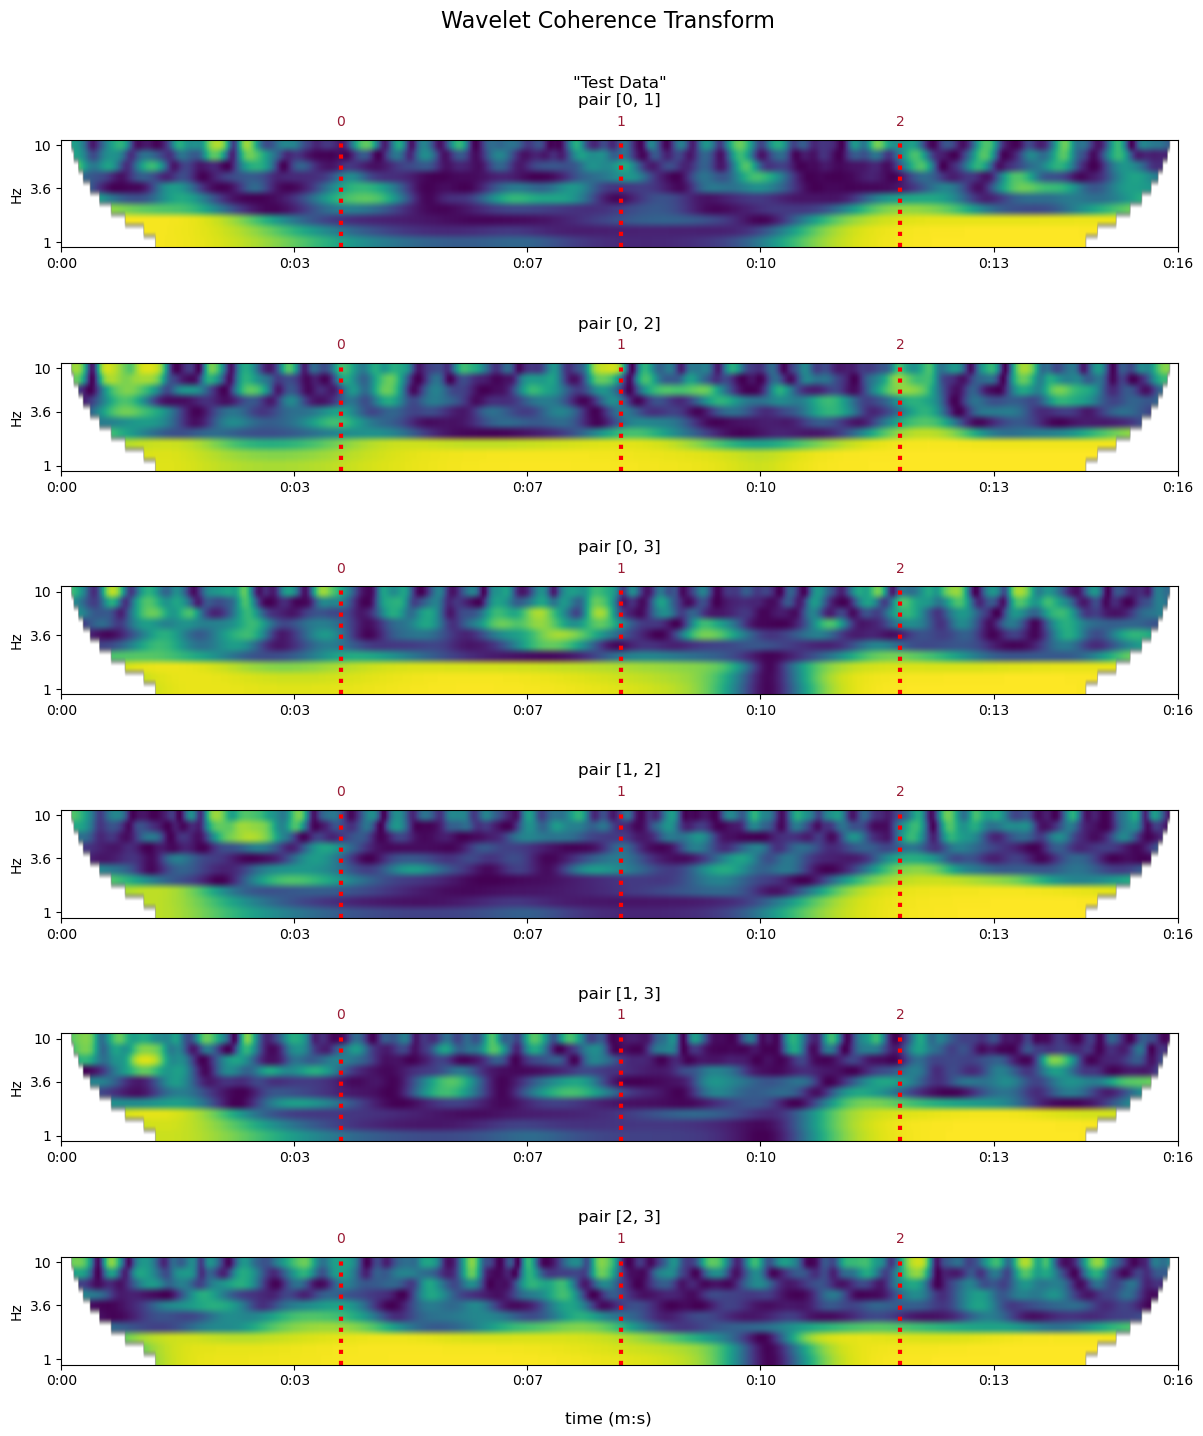

In [5]:
wct_freq = [1,10]  # <--- frequency (Hz): float or [minimum, maximum]
n_tscales = 10     # <--- number of time scales (i.e., frequency bins)

# wct_freq = 1     # <--- frequency (Hz): float or [minimum, maximum]

pairs_axis = 0
fixed_axes = -1
wctdata = sc.ptdata.wct( test_data_2, wct_freq, pairs_axis, fixed_axes, n_tscales=n_tscales,
                         postprocess='coinan' )
wctdata.visualise( dlattr='1.2' )

>
#### Average Wavelet Coherence Transform for group

C:\Users\juigmend\local_documents\SynCoord\src\syncoord\ptdata.py:1186: RuntimeWarning: Mean of empty slice
  dd_out[k] = np.nanmean(dd_in[k],axis=axis)


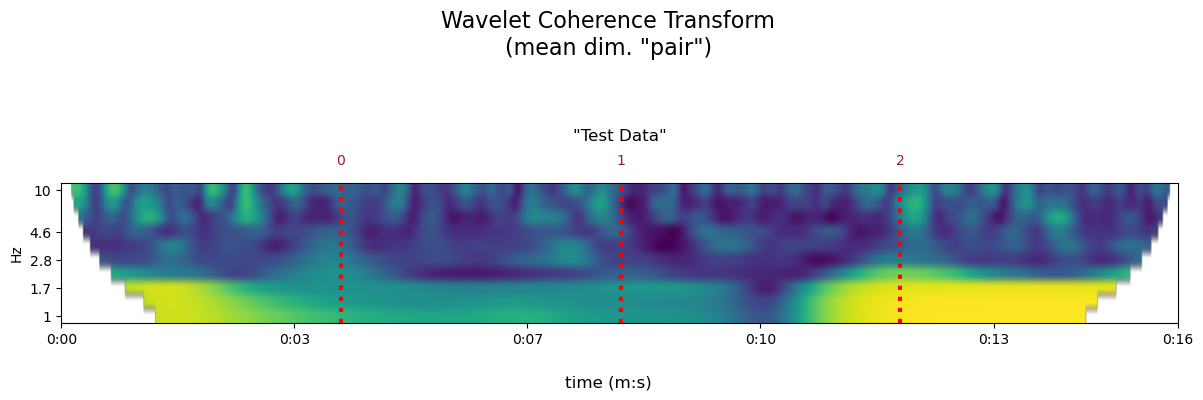

In [6]:
wctdata_aggr_pairs = sc.ptdata.aggrax( wctdata, axis=0, function='mean' )

max_n_nan = 0 # maximum number of frames affected by cone of influence
for row in wctdata_aggr_pairs.data[0]:
    n_nan_row = sum(np.isnan(row))
    if n_nan_row > max_n_nan: max_n_nan = n_nan_row

wctdata_aggr_pairs.visualise( vscale=1.4, dlattr='1.2' )

>
#### Average Wavelet Coherence Transform for group

C:\Users\juigmend\local_documents\SynCoord\src\syncoord\ptdata.py:1186: RuntimeWarning: Mean of empty slice
  dd_out[k] = np.nanmean(dd_in[k],axis=axis)


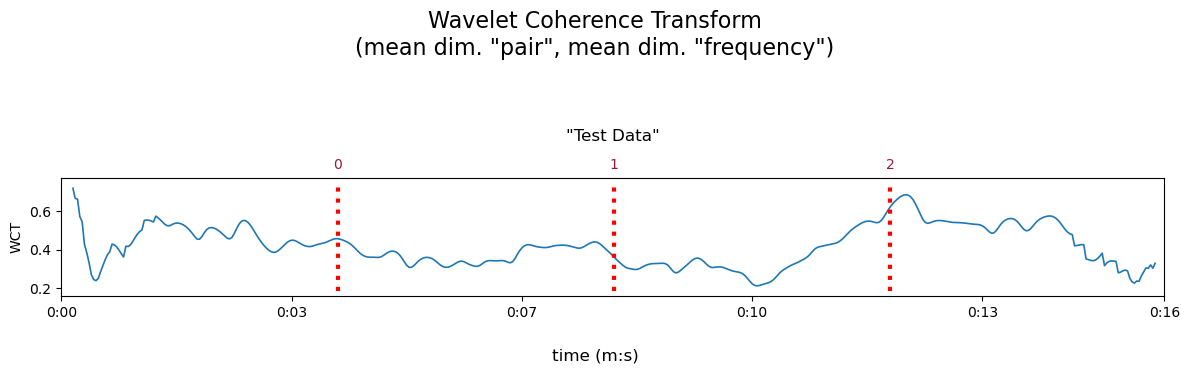

In [7]:
wctdata_aggr_top = sc.ptdata.aggrax( wctdata_aggr_pairs, axis=0, function='mean' )
wctdata_aggr_top.visualise( vscale=1.3, vistype='line', dlattr='1.2' )

>
#### Sections' statistics

means = [0.51, 0.334, 0.276, 0.531]


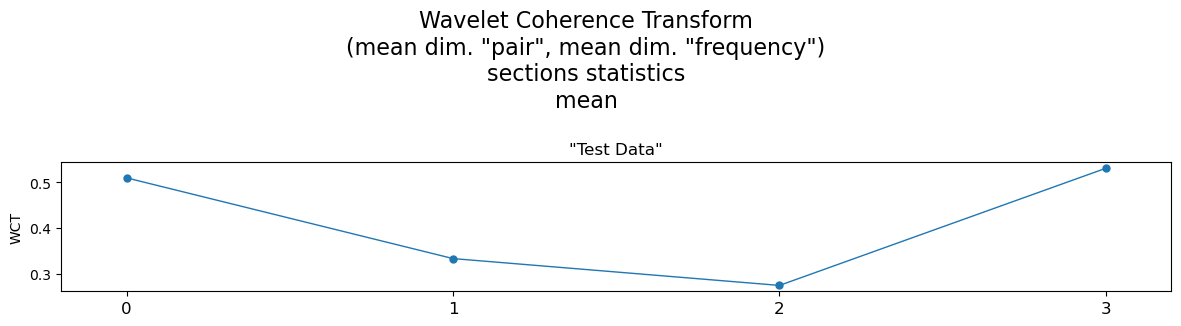

In [8]:
# Set margins to be as the maximum number of frames affected by the cone of influence:
margin_s = max_n_nan.item()/2/wctdata_aggr_top.topinfo.fps[0].item()
n_sections = len(wctdata_aggr_top.topinfo.trimmed_sections_frames[0])+1
sec_margins = [[margin_s,margin_s] for _ in range(n_sections)] # <--- sections' margins (seconds)

# sec_margins = None # <--- sections' margins (seconds)

wctdata_aggr_top_stats = sc.ptdata.secstats( wctdata_aggr_top, margins=sec_margins,
                                             omitnan=True, last=True )

wctdata_aggr_top_stats.visualise( statistics='mean' )
print('means =','['+', '.join([str(v) for v in np.round(wctdata_aggr_top_stats.data[0][0],3)])+']')

import matplotlib.pyplot as plt
plt.xlim((-0.2,3.2))
plt.xticks((0,1,2,3),('0','1','2','3'),fontsize=12);